### 0. Imports

In [209]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from google.colab import files
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, VarianceThreshold, RFE, SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# 1. Lectura de datos

In [210]:
# Evita tener que hacer la descarga cada vez que se quiere iniciar el proceso de cero. 
# Esta celda se ejecuta solo la primera vez
!wget -q http://tomasdelvechio.github.io/subjects/dm/udemy_entrenamiento.xlsx
!wget -q http://tomasdelvechio.github.io/subjects/dm/udemy_prueba.xlsx

In [211]:
df_entrenamiento = pd.read_excel('udemy_entrenamiento.xlsx', index_col="id")

# fix de error en la clase, era "si", no "yes" (En kaggle)
df_entrenamiento.loc[df_entrenamiento['bestseller'] == "yes", 'bestseller'] = "si"

In [212]:
df_prueba = pd.read_excel('udemy_prueba.xlsx', index_col="id")

## 1.1. Tratamiento de desbalance

Existe un desbalance de la clase `bestseller`. Se armaron 3 opciones. Por default, se mantiene el desbalance original 80 / 20 en favor del valor "no".

Las 2 alternativas que se exploran (ver sección 2.6) son: 

- Reducir los "no" para generar un rebalance 65 / 35.
- Reducir los "no" para generar un rebalance 50 / 50.

In [213]:
# Quitar Duplicados?
QUITAR_DUPLICADOS = False
if QUITAR_DUPLICADOS:
  df_entrenamiento = df_entrenamiento.drop_duplicates()
# TD: Mis pruebas dan que el borrado de duplicates es irrelevante

In [214]:
PROPORCION_ELEGIDA="mantener_desbalance_80/20"
#PROPORCION_ELEGIDA="rebalancear_65/35" NO ESTA FUNCIONANDO
#PROPORCION_ELEGIDA="rebalancear_50/50"

if PROPORCION_ELEGIDA == "mantener_desbalance_80/20":
  df_entrenamiento_proporcionado = df_entrenamiento
else:
  g = df_entrenamiento.groupby('bestseller')
  if PROPORCION_ELEGIDA == "rebalancear_65/35":
    muestras_a_tomar = 4100
  elif PROPORCION_ELEGIDA == "rebalancear_50/50":
    muestras_a_tomar = g.size().min() # 2.200
  df_entrenamiento_proporcionado = (g.apply(lambda x: x.sample(muestras_a_tomar, random_state=1))).reset_index(drop=True)
  df_entrenamiento_proporcionado.index.name = "id"
  df_entrenamiento_proporcionado = g.apply(lambda x: x.sample(muestras_a_tomar)) #.reset_index(drop=True))

Para probar el balance elegido, ejecutar:

In [215]:
#print(df_entrenamiento_proporcionado.bestseller.value_counts(normalize=False))
#print(df_entrenamiento_proporcionado.bestseller.value_counts(normalize=True))
if PROPORCION_ELEGIDA == "rebalancear_50/50":
  assert df_entrenamiento_proporcionado.bestseller.value_counts()[0] == 2200
  assert df_entrenamiento_proporcionado.bestseller.value_counts()[1] == 2200

if PROPORCION_ELEGIDA == "mantener_desbalance_80/20" and not QUITAR_DUPLICADOS:
  assert df_entrenamiento.bestseller.value_counts()[0] == 8887
  assert df_entrenamiento.bestseller.value_counts()[1] == 2200

## 1.2. Preparación de DataFrame

Una vez cargados ambos datasets, hay que concatenarlos en uno solo para que el tratamiento de las columnas sea consistente.

Se volverá a separar recien en la sección 5.

In [216]:
df = pd.concat([df_entrenamiento_proporcionado, df_prueba], axis=0)

# Se crea mascara para cada dataset, para filtrar cuando se hagan calculos por columnas
mascara_filtra_entrenamiento = df['bestseller'].notna()
mascara_filtra_pruebas = df['bestseller'].isna()

In [217]:
# Se prueba que las mascaras funcionen
assert df_entrenamiento_proporcionado.shape == df[mascara_filtra_entrenamiento].shape
assert df_prueba.shape == df[mascara_filtra_pruebas].shape

# Modelización


## Funciones generales

In [218]:
def imputacion_simple(df, columnas, df_train=None, strategy='median'):
    if df_train is None:
        # escenario de imputacion del propio df de entrenamiento
        df_train = df
    df_train_copy = df_train[columnas].copy()

    imp = SimpleImputer(strategy=strategy)
    # strategy == mean, median, most_frequent, constant
    imputador = imp.fit(df_train_copy)
    df_imputado = imputador.transform(df[columnas])
    return pd.DataFrame(df_imputado, columns=columnas, index=df.index)

In [219]:
DROPNA=False

if DROPNA:
  dfe = df_entrenamiento.dropna()[df_entrenamiento.columns].copy()
  dfp = df_prueba[df_prueba.columns].copy()
else:
  dfe = df_entrenamiento[df_entrenamiento.columns].copy()
  dfp = df_prueba[df_prueba.columns].copy()


In [220]:
dfe.head()

,title,headline,is_practice_test_course,bestseller,captions,rating,num_published_lectures,num_published_practice_tests,locale,created_date,instructional_level_simple,published_date,last_update_date,content_info_short,instructors,category,subcategory,objectives,list_price,discount_price
id,,,,,,,,,,,,,,,,,,,,
1,Aprende a tocar Piano o Teclado (Desde nivel b...,Curso completo de Piano con TEORÍA para el fun...,False,no,es_LA,4.535809,58,1,es_LA,2012-01-26,Todos los niveles,2012-01-26,2021-05-19,4 horas,121211,Música,Piano,Aprende Piano desde nivel básico. Estudiaras l...,$34.99,$12
2,Curso Hipoterapia y Rehabilitacion Ecuestre On...,"Terapias asistidas por Caballos (Hipoterapia, ...",False,no,es_ES,4.133590,32,0,es_ES,2012-06-10,Principiante,2012-06-10,2015-12-17,10 horas,236127,Estilo de vida,Adiestramiento de mascotas,La Hipoterapia y la Psicología.La Hipoterapia ...,$99.99,NaN
3,Curso SEO Online,Curso SEO práctico. Aprenda a posicionar su si...,False,no,es_ES,3.841912,76,0,es_ES,2011-06-13,Todos los niveles,2012-07-03,2020-02-28,"6,5 horas",3851,Marketing,SEO,Entender los fundamentos del SEO.Aprender a ha...,$94.99,$12
4,Aprende CSS3 sin dolor,"Realiza animaciones asombrosas, antes imposibl...",False,no,es_MX,4.039739,68,0,es_MX,2012-08-30,Intermedio,2012-08-31,2019-09-08,"9,5 horas",171706,Desarrollo,CSS,El alumno conocerá las principales característ...,$19.99,$12
5,"Aprende Javascript, HTML5 y CSS3",Aprende los principales lenguajes que dominan ...,False,si,NaN,4.643154,550,0,es_MX,2012-08-30,Todos los niveles,2012-09-02,2021-03-04,"70,5 horas",171706,Desarrollo,JavaScript,"Desarrollar páginas dinámicas con JavaScript, ...",$29.99,$12


In [221]:
def categorizar_columna(df, nombre_columna):
  fq_col = df.groupby(nombre_columna).size()/len(df)  
  new_col = df[nombre_columna].map(fq_col)
  return pd.DataFrame(new_col, columns = [nombre_columna])

columnas_a_categorizar = [
#  'is_practice_test_course',
  'captions',
  'locale',
  'instructional_level_simple',
#  'content_info_short',
  'instructors',
  'category',
  'subcategory',
#  'list_price',
#  'discount_price',
]

#for columna in list(dfe.columns):
for columna in columnas_a_categorizar:
  if columna == 'bestseller':
    continue
  dfe[f"{columna}_prop"] = categorizar_columna(dfe, columna)
  dfp[f"{columna}_prop"] = categorizar_columna(dfp, columna)


In [222]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11087 entries, 1 to 11087
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            11087 non-null  object 
 1   headline                         11086 non-null  object 
 2   is_practice_test_course          11087 non-null  bool   
 3   bestseller                       11087 non-null  object 
 4   captions                         9142 non-null   object 
 5   rating                           11087 non-null  float64
 6   num_published_lectures           11087 non-null  int64  
 7   num_published_practice_tests     11087 non-null  int64  
 8   locale                           11087 non-null  object 
 9   created_date                     11087 non-null  object 
 10  instructional_level_simple       11082 non-null  object 
 11  published_date                   11087 non-null  object 
 12  last_update_date  

In [223]:
dfe.shape

(11087, 26)

In [224]:
col_a_imputar_simple = ['discount_price']
TRATAMIENTO_FINO_NAN = True
if TRATAMIENTO_FINO_NAN:
  columnas_a_borrar_por_nans = dfe.columns[dfe.isna().sum() > 20].drop(col_a_imputar_simple).tolist()
  dfe = dfe[dfe.columns.drop(columnas_a_borrar_por_nans)]
  dfp = dfp[dfp.columns.drop(columnas_a_borrar_por_nans)]
  dfe = dfe.dropna()[dfe.columns].copy()
  dfe['discount_price'] = dfe['discount_price'].str.strip('$').astype(float)
  dfp['discount_price'] = dfp['discount_price'].str.strip('$').astype(float)
  dfe[col_a_imputar_simple] = imputacion_simple(dfe, col_a_imputar_simple)
  dfp[col_a_imputar_simple] = imputacion_simple(dfp, col_a_imputar_simple)

dfe.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(10077, 23)

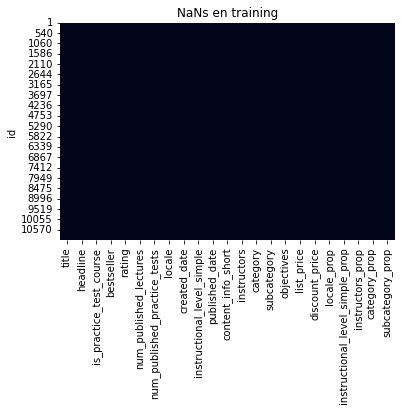

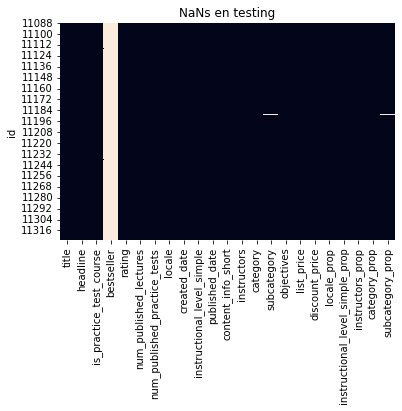

In [225]:
def plot_nans(df, title="NaNs presentes en DF"):
    ax = plt.axes()
    sns.heatmap(df.isnull(), cbar=False, ax=ax)
    ax.set_title(title)
    plt.show()

plot_nans(dfe, "NaNs en training")
plot_nans(dfp, "NaNs en testing")

In [226]:
# Hacemos una imputación a manopla
dfp.subcategory_prop.fillna(0.004184, inplace=True)

In [227]:
# En testing no nos queda otra opción que imputar todo

non_numeric_columns = []
only_numeric_columns = []
for c in dfe.columns:
    if dfe[c].map(type).eq(str).any(): #check if there are any strings in column
        non_numeric_columns.append(c)
    elif dfe[c].map(type).eq(bool).any():
        non_numeric_columns.append(c)
    else:
        only_numeric_columns.append(c)

dfp_only_numeric = dfp[only_numeric_columns]
dfe_only_numeric = dfe[only_numeric_columns]
dfp_non_numeric = pd.DataFrame(dfp[non_numeric_columns])

def imputacion_simple(df, columnas, df_train=None, strategy='median'):
    if df_train is None:
        # escenario de imputacion del propio df de entrenamiento
        df_train = df
    df_train_copy = df_train[columnas].copy()

    imp = SimpleImputer(strategy=strategy)
    imputador = imp.fit(df_train_copy)
    df_imputado = imputador.transform(df)
    return pd.DataFrame(df_imputado, columns=columnas, index=df.index)

dfp_only_numeric = pd.DataFrame(imputacion_simple(dfp_only_numeric, dfp_only_numeric.columns, dfe_only_numeric), columns=dfp_only_numeric.columns) #only apply imputer to numeric columns

dfp = pd.concat([dfp_only_numeric, dfp_non_numeric], axis = 1)


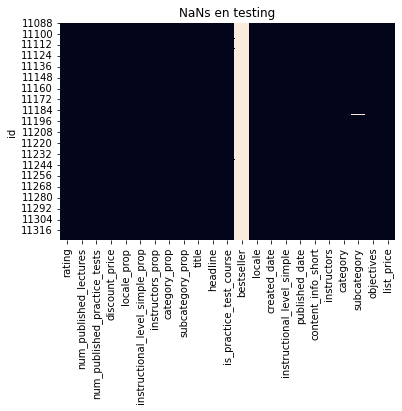

In [228]:
plot_nans(dfp, "NaNs en testing")

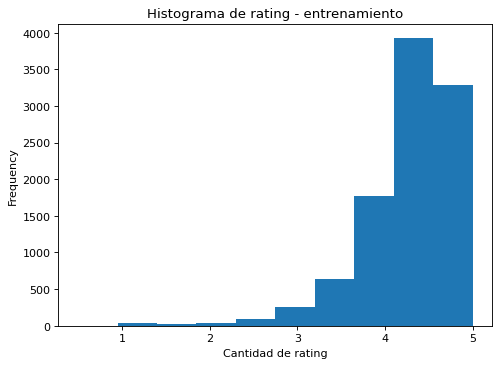

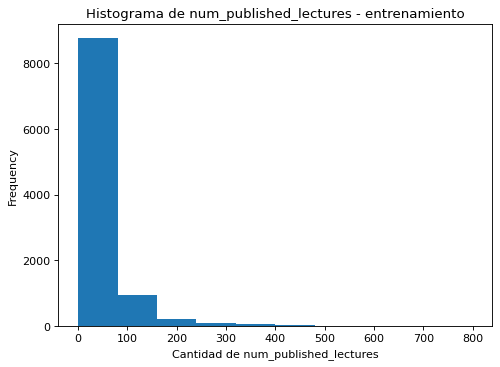

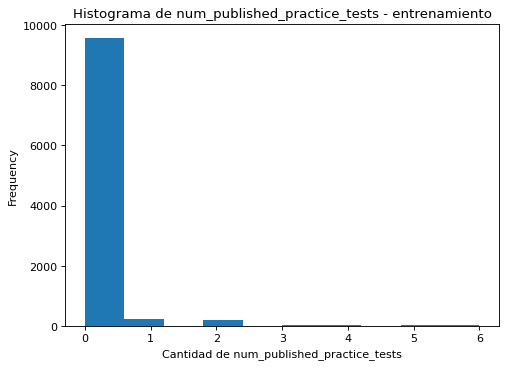

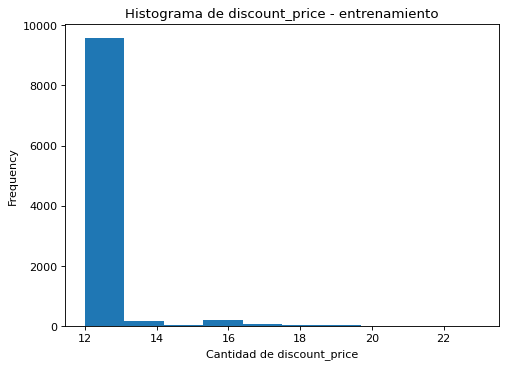

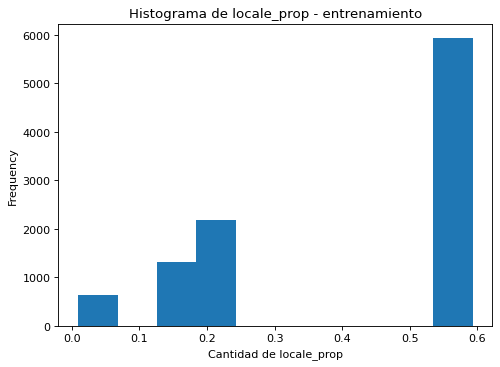

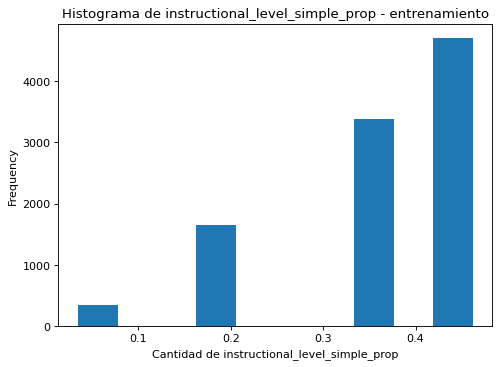

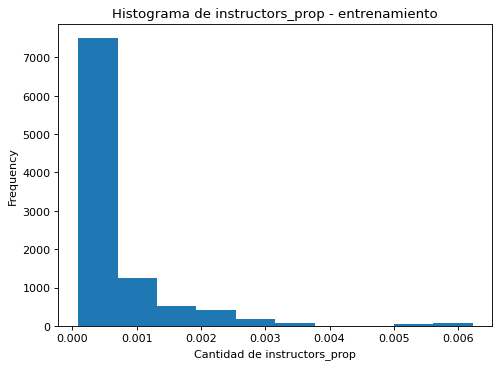

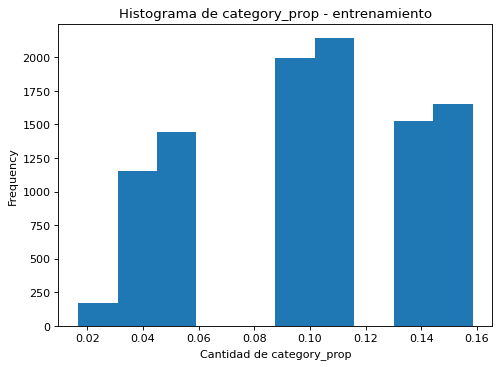

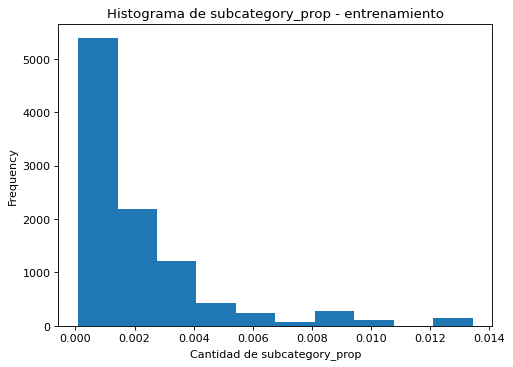

In [229]:
# Histogramas de variables
def graficar_histogramas(df, columns, ds_type="entrenamiento"):
  for column in columns:
    plt.figure(figsize=(7, 5), dpi=80)
    ax = df[column].plot.hist()
    ax.set_title(f"Histograma de {column} - {ds_type}")
    ax.set_xlabel(f"Cantidad de {column}")
    plt.show()

graficar_histogramas(dfe, only_numeric_columns)

## Pair Plot

In [230]:
if False:
  sns.pairplot(dfe);

## Text Minig 2.0

In [231]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


dfe['title'] = dfe['title'].str.lower()
dfp['title'] = dfp['title'].str.lower()
dfe['headline'] = dfe['headline'].str.lower()
dfp['headline'] = dfp['headline'].str.lower()
dfe['objectives'] = dfe['objectives'].str.lower()
dfp['objectives'] = dfp['objectives'].str.lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [232]:
dfc = pd.concat([dfe, dfp], axis=0)

dfc["Texto"] =dfc['title']+" "+ dfc["headline"]+" "+ dfc["objectives"]
dfc['Texto'].astype(str) 

id
1        aprende a tocar piano o teclado (desde nivel b...
3        curso seo online curso seo práctico. aprenda a...
4        aprende css3 sin dolor realiza animaciones aso...
5        aprende javascript, html5 y css3 aprende los p...
7        html5 aprenda a la poderosa herramienta que ha...
                               ...                        
11322    bootcamp de redacción publicitaria (copywritin...
11323    estructuras de acero i: elementos a compresión...
11324    fortinet security 6.4 - nse4 conviértase en un...
11325    sanando a tu niña interior ¡reencuéntrate con ...
11326    amazon aws certified solutions architect saa-c...
Name: Texto, Length: 10316, dtype: object

In [233]:
dfc.Texto.describe

<bound method NDFrame.describe of id
1        aprende a tocar piano o teclado (desde nivel b...
3        curso seo online curso seo práctico. aprenda a...
4        aprende css3 sin dolor realiza animaciones aso...
5        aprende javascript, html5 y css3 aprende los p...
7        html5 aprenda a la poderosa herramienta que ha...
                               ...                        
11322    bootcamp de redacción publicitaria (copywritin...
11323    estructuras de acero i: elementos a compresión...
11324    fortinet security 6.4 - nse4 conviértase en un...
11325    sanando a tu niña interior ¡reencuéntrate con ...
11326    amazon aws certified solutions architect saa-c...
Name: Texto, Length: 10316, dtype: object>

In [234]:
regexp = RegexpTokenizer('\w+')
dfc["Texto"] = dfc["Texto"].apply(regexp.tokenize)

dicc_palabras = {'aprende': 'aprender', 'bases':'base', 'bases datos':'base datos', 'completa': 'completo', 'conocimientos': 'conocimiento', 'desarrollar':'desarrollo', 'disenar': 'diseno', 'gestionar': 'gestion',
                 'herramientas': 'herramienta', 'manejar':'manejo', 'mejores':'mejor', 'modelos': 'modelo', 'negocios':'negocio', 'paginas': 'pagina', 'practicas': 'practica', 'practicos':'practico',
                 'procesos':'proceso', 'profesionales': 'profesional', 'programar': 'programacion', 'proyectods': 'proyecto', 'tecnica': 'tecnicas', 'videos': 'video'}


dfc['Texto'] = dfc['Texto'].apply(lambda texto: [dicc_palabras.get(token, token) for token in texto])
dfc['Texto']
#dfp["Texto"] = dfp["Texto"].apply(regexp.tokenize)

stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo', 'con', 'en', 'conocer', 'crear', 'utilizar', 'hacer', 'como', '10', '100', '2021','analizar','aprenderas','capaz', 
                  'cero', 'comprender', 'conoceras',
       'construir', 'conviertete', 'crea','cualquier', 
        'domina', 'dominar', 'etc', 'generar',
        'identificar', 'implementar','instalar','mas',
       'mejorar', 'obtener', 'poder', 'podras','realizar', 'saber', 'ser',
       'server', 'tener', 'tipo', 'tipos', 'todas', 'trabajar',
       'trabajo', 'traves', 'usando', 'usar', 'uso',
       'utilizando', 'vender', '2020'])

dfc['Texto'] = dfc['Texto'].apply(lambda texto: [token for token in texto if token not in stopwords])
#dfp['Texto'] = dfp['Texto'].apply(lambda texto: [token for token in texto if token not in stopwords])
dfc['Texto']

id
1        [aprender, tocar, piano, teclado, nivel, básic...
3        [curso, seo, online, curso, seo, práctico, apr...
4        [aprender, css3, dolor, realiza, animaciones, ...
5        [aprender, javascript, html5, css3, aprender, ...
7        [html5, aprenda, poderosa, herramienta, revolu...
                               ...                        
11322    [bootcamp, redacción, publicitaria, copywritin...
11323    [estructuras, acero, i, elementos, compresión,...
11324    [fortinet, security, 6, 4, nse4, conviértase, ...
11325    [sanando, niña, interior, reencuéntrate, niña,...
11326    [amazon, aws, certified, solutions, architect,...
Name: Texto, Length: 10316, dtype: object

In [235]:
dfc['Texto'] = dfc['Texto'].str.join(' ')
#dfp['Texto'] = dfp['Texto'].str.join(' ')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Modelo Top 15 columnas

In [236]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.009, max_df=0.7, strip_accents='ascii', max_features=15)
vectorized_data = vectorizer.fit_transform(dfc['Texto'])

count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
count_df.index = dfc.index 
dfc = pd.concat([dfc, count_df], axis=1)
display(dfc)

,title,headline,is_practice_test_course,bestseller,rating,num_published_lectures,num_published_practice_tests,locale,created_date,instructional_level_simple,...,curso,datos,desarrollo,forma,herramienta,paso,profesional,programacion,tecnicas,web
id,,,,,,,,,,,,,,,,,,,,,
1,aprende a tocar piano o teclado (desde nivel b...,curso completo de piano con teoría para el fun...,False,no,4.535809,58.0,1.0,es_LA,2012-01-26,Todos los niveles,...,2,0,0,0,0,0,0,0,0,0
3,curso seo online,curso seo práctico. aprenda a posicionar su si...,False,no,3.841912,76.0,0.0,es_ES,2011-06-13,Todos los niveles,...,2,0,0,0,0,0,0,0,0,2
4,aprende css3 sin dolor,"realiza animaciones asombrosas, antes imposibl...",False,no,4.039739,68.0,0.0,es_MX,2012-08-30,Intermedio,...,0,0,0,0,0,0,0,0,0,0
5,"aprende javascript, html5 y css3",aprende los principales lenguajes que dominan ...,False,si,4.643154,550.0,0.0,es_MX,2012-08-30,Todos los niveles,...,0,0,1,0,0,0,0,0,0,0
7,html5,aprenda a la poderosa herramienta que ha revol...,False,no,3.926147,165.0,0.0,es_LA,2012-09-03,Todos los niveles,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11322,bootcamp de redacción publicitaria (copywritin...,puede escribir un texto que venda: redes socia...,False,NaN,4.155691,65.0,0.0,es_LA,2021-03-31,Todos los niveles,...,0,0,0,0,0,0,0,0,0,2
11323,estructuras de acero i: elementos a compresión,conceptos y aplicación con referencia al aisc ...,False,NaN,4.818863,16.0,0.0,es_LA,2021-03-31,Intermedio,...,0,0,0,0,0,0,0,0,0,0
11324,fortinet security 6.4 - nse4,conviértase en un especialista en el corto tie...,False,NaN,3.740466,40.0,0.0,es_ES,2021-03-31,Intermedio,...,0,0,0,0,0,0,0,0,0,0


### Modelo Top 200 (1 sola columna)

In [237]:
vectorizer200 = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.009, max_df=0.9, strip_accents='ascii', max_features=200)
vectorizer200._validate_vocabulary()

vectorized_data_200 = vectorizer200.fit_transform(dfc['Texto'])


tfidf_df = pd.DataFrame(vectorized_data_200.toarray(), columns=vectorizer200.get_feature_names_out())
tfidf_df['200_palabras_clave'] = tfidf_df[list(tfidf_df.columns)].sum(axis=1)

dfc['200_palabras_clave'] = tfidf_df['200_palabras_clave'] 
dfc['200_palabras_clave'] = dfc['200_palabras_clave'].fillna(value = 0)


In [238]:
dfc['200_palabras_clave'].isna().sum()

0

## Vuelvo a separar en entrenamiento y prueba

In [239]:
dfp = dfc.loc[dfc['bestseller'].isna()].copy()
#df_pred.index.name = "id" 
dfe = dfc.loc[dfc['bestseller'].notna()].copy()

## Date to Number

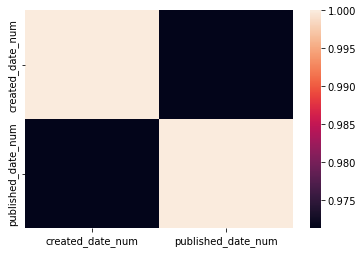

In [240]:
df_date = pd.concat([dfe, dfp], axis=0)

df_date["created_date_num"] = pd.to_datetime(df_date["created_date"])
df_date['created_date_num'] = df_date['created_date_num'].apply(lambda x: x.value)
df_date['created_date_num'] = df_date['created_date_num'].astype(float)

df_date['published_date_num'] = pd.to_datetime(df_date["published_date"])
df_date['published_date_num'] = df_date['published_date_num'].apply(lambda x: x.value)
df_date['published_date_num'] = df_date['published_date_num'].astype(float)

if not TRATAMIENTO_FINO_NAN:
  df_date['last_update_date_num'] = pd.to_datetime(df_date["last_update_date"])
  df_date['last_update_date_num'] = df_date['last_update_date_num'].apply(lambda x: x.value)
  df_date['last_update_date_num'] = df_date['last_update_date_num'].astype(float)
  cols_to_corr = ['created_date_num','published_date_num', 'last_update_date_num']
else:
  cols_to_corr = ['created_date_num','published_date_num'] 

dfcorr = df_date[df_date.bestseller.isna() == False]

columnas_corr = cols_to_corr

dfcorr = dfcorr[columnas_corr]

sns.heatmap(dfcorr.corr())

In [241]:
dfp = df_date.loc[df_date['bestseller'].isna()].copy()
#df_pred.index.name = "id" 
dfe = df_date.loc[df_date['bestseller'].notna()].copy()

In [242]:
if not TRATAMIENTO_FINO_NAN:
  max_lud = dfe.last_update_date_num.max()
  min_lud = dfe.last_update_date_num.min()

  dfp['last_update_date_num'] = (dfp['last_update_date_num']-min_lud)/(max_lud-min_lud)
  dfe['last_update_date_num'] = (dfe['last_update_date_num']-min_lud)/(max_lud-min_lud)

In [243]:
max_pdn = dfe.published_date_num.max()
min_pdn = dfe.published_date_num.min()

dfp['published_date_num'] = (dfp['published_date_num']-min_pdn)/(max_pdn-min_pdn)
dfe['published_date_num'] = (dfe['published_date_num']-min_pdn)/(max_pdn-min_pdn)

## Columna de instructores con Bestsellers en Entrenamiento


In [244]:
from sklearn.naive_bayes import CategoricalNB

bagger = CountVectorizer()
instructors = dfe['instructors'].str.replace(',', ' ')
bagger.fit(instructors)
bow = bagger.transform(instructors)

nb = CategoricalNB()
nb.fit(bow.toarray(), dfe['bestseller'])

pdnb_e = pd.DataFrame(nb.predict_proba(bow.toarray()), index=dfe.index, columns=nb.classes_)

bow_testing = bagger.transform(dfp['instructors'].str.replace(',', ' '))
pdnb_p = pd.DataFrame(nb.predict_proba(bow_testing.toarray()), index=dfp.index, columns=nb.classes_)

In [245]:
dfe["nb_si"] = pdnb_e["si"]
dfp["nb_si"] = pdnb_p["si"]

## Columnas Varias

In [246]:
df = pd.concat([dfe, dfp], axis=0)


df['precio_como_numero'] = df.list_price.str[1:].astype('float')
if TRATAMIENTO_FINO_NAN:
  df['precio_neto'] = df['discount_price']
else:
  df['precio_neto'] = (df['discount_price'].str.strip('$').astype(float))
df['precio_neto'] = df['precio_neto'].fillna(df['precio_como_numero'])

#tiene_descuento = np.where(df['precio_como_numero'] != df['precio_neto'], True, False)
#df['tiene_descuento'] = tiene_descuento

df['descuento_aplicado'] = df['precio_como_numero'] - df['precio_neto']


df['cantidad_instructores'] = df.instructors.str.count(',') + 1 # Contamos las comas, mas 1
df['cantidad_instructores'] = df['cantidad_instructores'].fillna(1) # Instructor con NaN lo tomamos como 1


cursos_por_instructor = dict(df[mascara_filtra_entrenamiento].instructors.str.get_dummies(sep=',').sum())

def asignar_cantidad_cursos_dictados(fila, cursos_por_instructor):
  try:
    instructores_del_curso = fila.instructors.split(',')
  except AttributeError as ae:
    # esto pasa cuando fila.instructors es NaN
    return 1

  cantidad_cursos_dictados = 0
  for instructor in instructores_del_curso:
    if instructor not in cursos_por_instructor.keys():
      cursos_por_instructor[instructor] = 0
    cantidad_cursos_dictados += cursos_por_instructor[instructor]
  return cantidad_cursos_dictados

def asignar_cantidad_cursos_dictados_media(fila, cursos_por_instructor):
  try:
    instructores_del_curso = fila.instructors.split(',')
  except AttributeError as ae:
    # esto pasa cuando fila.instructors es NaN
    return 1

  cantidad_cursos_dictados = []
  for instructor in instructores_del_curso:
    if instructor not in cursos_por_instructor.keys():
      cursos_por_instructor[instructor] = 0
    cantidad_cursos_dictados.append(cursos_por_instructor[instructor])
  return sum(cantidad_cursos_dictados)/len(cantidad_cursos_dictados)

df['cantidad_cursos_dictados'] = df.apply(asignar_cantidad_cursos_dictados, axis=1, args=(cursos_por_instructor,))
#df['cantidad_cursos_dictados_media'] = df.apply(asignar_cantidad_cursos_dictados_media, axis=1, args=(cursos_por_instructor,))

df['examen']= df.loc[df['is_practice_test_course'] == True, 'content_info_short'].str.replace(' preguntas', '').astype('float')
df['examen']=df['examen'].fillna(0)

df['content_info_string']=df['content_info_short'].str.split(' ').str[1]
df['content_info_string'] = df['content_info_string'].str.replace('s', '')
df['horas_cursada']= df['content_info_short'].str.replace(',', '.').str.replace('s', '')
df['horas_cursada'] = df.loc[df['content_info_string'] == 'hora', 'horas_cursada'].str.replace(' hora', '').astype('float')
df['minutos_cursada'] = df['content_info_short'].str.replace(',', '.').str.replace('s', '')
df['minutos_cursada'] = df.loc[df['content_info_string'] == 'minuto', 'minutos_cursada'].str.replace(' minuto', '').astype('float')
df['minutos_cursada'] = df['minutos_cursada'].div(60)
df['horas_cursada'] = df['horas_cursada'].fillna(df['minutos_cursada'])
df['horas_cursada_media'] = df['horas_cursada'].fillna((df[mascara_filtra_entrenamiento]['horas_cursada'].median()))

df['costo_por_hora'] = df['precio_neto']/df['horas_cursada_media']


# Vuelvo a separar

dfp = df.loc[df['bestseller'].isna()].copy()
#df_pred.index.name = "id" 
dfe = df.loc[df['bestseller'].notna()].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Modelización 2.0

In [247]:
dfe.isna().sum()

title                                 0
headline                              0
is_practice_test_course               0
bestseller                            0
rating                                0
num_published_lectures                0
num_published_practice_tests          0
locale                                0
created_date                          0
instructional_level_simple            0
published_date                        0
content_info_short                    0
instructors                           0
category                              0
subcategory                           0
objectives                            0
list_price                            0
discount_price                        0
locale_prop                           0
instructional_level_simple_prop       0
instructors_prop                      0
category_prop                         0
subcategory_prop                      0
Texto                                 0
aprender                              0


In [248]:
#df_entrenamiento.isna().sum()
#df_entrenamiento.dropna().shape
if TRATAMIENTO_FINO_NAN:
  columnas_a_eliminar = [
    'title',
    'headline',
    'created_date',
    'published_date',
    'objectives',
    'created_date_num',
    'Texto',
    #'200_palabras_clave',   #solucionado
    'is_practice_test_course',
    'locale',
    'instructional_level_simple',
    'content_info_short',
    'instructors',
    'category',
    'subcategory',
    'list_price',
    'discount_price',
    'content_info_string',
    'horas_cursada',
    'minutos_cursada'
  ]
else:
  columnas_a_eliminar = [
    'title',
    'headline',
    'created_date',
    'published_date',
    'last_update_date',
    'objectives',
    'created_date_num',
    'Texto',
    #'200_palabras_clave',   #solucionado
    'is_practice_test_course',
    'captions',
    'locale',
    'instructional_level_simple',
    'content_info_short',
    'instructors',
    'category',
    'subcategory',
    'list_price',
    'discount_price',
    'content_info_string',
    'horas_cursada',
    'minutos_cursada'
  ]


In [249]:
## EL SIGUIENTE DROPNA BORRA VARIOS MILES DE REGISTROS. SE HIZO PARA NO IMPUTAR
#dfe1 = dfe.dropna()[dfe.columns.drop(columnas_a_eliminar)].copy()
#dfp1 = dfp[dfp.columns.drop(columnas_a_eliminar)].copy()

dfe = dfe[dfe.columns.drop(columnas_a_eliminar)].copy()
dfp = dfp[dfp.columns.drop(columnas_a_eliminar)].copy()

dfe = dfe.dropna()

In [250]:
print(dfe.shape)
print(dfp.shape)

(10077, 35)
(239, 35)


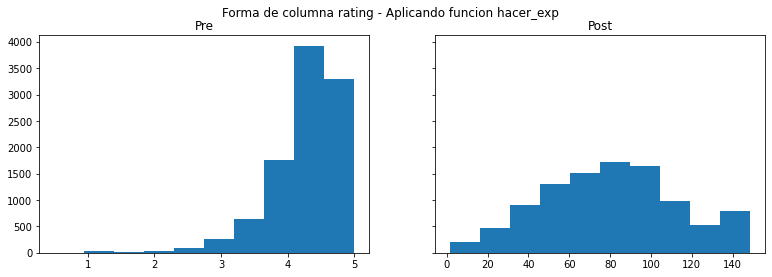

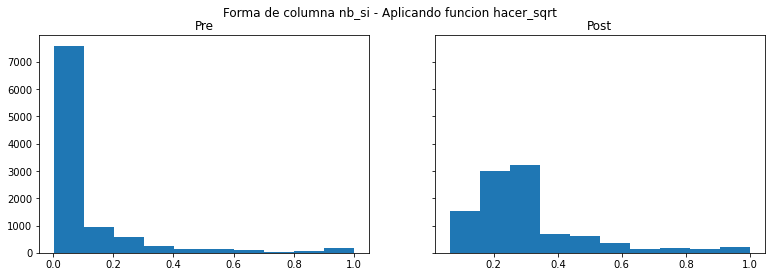

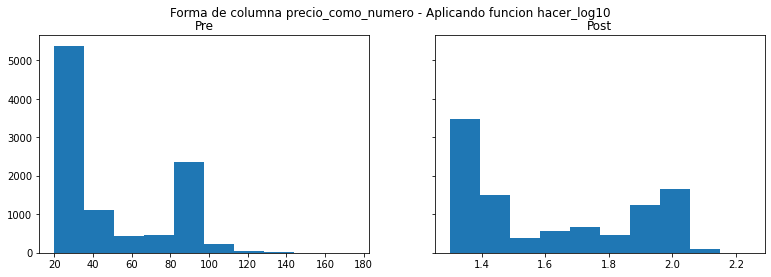

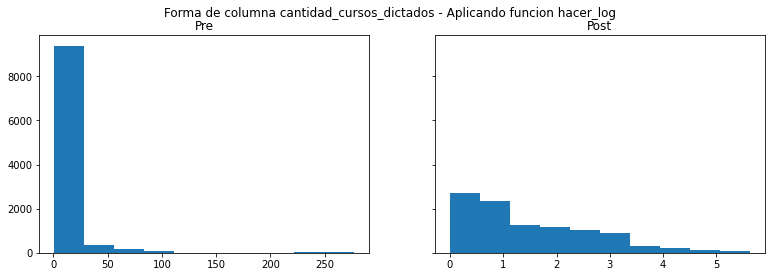

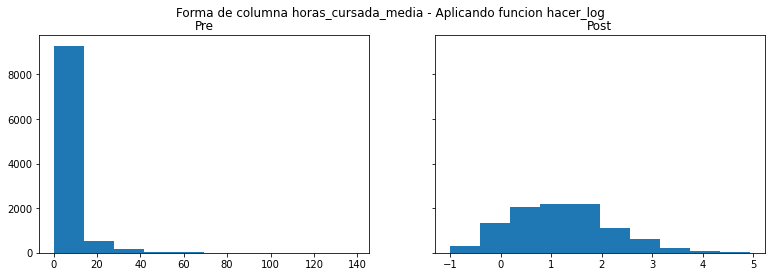

In [251]:
def hacer_log(df):
  return np.log(df)

def hacer_log10(df):
  return np.log10(df)

def hacer_exp(df):
  return np.exp(df)

def hacer_sqrt(df):
  return np.sqrt(df)

# Estandarización selectiva
estandarizador_por_columna = {
    'rating': hacer_exp,
    'nb_si': hacer_sqrt,
    'precio_como_numero': hacer_log10,
    'cantidad_cursos_dictados': hacer_log,
    #'num_published_lectures': hacer_log,
    'horas_cursada_media': hacer_log,
}

for columna, funcion in estandarizador_por_columna.items():
  figure, ax = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
  
  figure.suptitle(f'Forma de columna {columna} - Aplicando funcion {funcion. __name__}')

  ax[0].hist(dfe[columna])
  ax[0].set_title("Pre")
  
  ax[1].hist(funcion(dfe[columna]))
  ax[1].set_title("Post")
  
  plt.show()


In [252]:
INPLACE=True # Aplica a los dfs lo visto en la celda anterior
if INPLACE:
  dfe[columna] = funcion(dfe[columna])
  dfp[columna] = funcion(dfp[columna])

In [253]:
import numpy as np
from sklearn.decomposition import PCA

X_PCA = dfe
X_PCA = X_PCA.drop(['bestseller'], axis = 1)

pca = PCA()
pca.fit(X_PCA)

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X_PCA.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {i+1: most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_PCA = pd.DataFrame(sorted(dic.items()))

ColsPCA = list(set(list(df_PCA[:5][1]) + ['nb_si']))

In [254]:
df_PCA

,0,1
0,1,num_published_lectures
1,2,precio_como_numero
2,3,examen
3,4,cantidad_cursos_dictados
4,5,costo_por_hora
5,6,precio_neto
6,7,200_palabras_clave
7,8,aprender
8,9,curso
9,10,web


In [255]:
USAR_PCA = False

if USAR_PCA:
  # PCA
  X_prueba = dfp[ColsPCA]

  # Arma los dfs definitivos de entrenamiento para fitear
  X = dfe[ColsPCA]
  y = dfe['bestseller']
else:
  X_prueba = dfp[dfp.columns.drop('bestseller')]

  # Arma los dfs definitivos de entrenamiento para fitear
  X = dfe[dfe.columns.drop('bestseller')]
  y = dfe['bestseller']

In [256]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, accuracy_score

if False:
  # el mejor dio:
  # RandomForestClassifier(max_depth=20, n_estimators=160, random_state=42)
  params_grid = {
    'n_estimators': list(range(200,300,10)),
    'max_depth': list(range(2,10,1)),
  }

  #RandomForestClassifier(criterion='entropy', max_depth=21, max_features='sqrt',
  #                     min_samples_leaf=7, min_samples_split=7, n_estimators=55,
  #                     random_state=42)
  #0.8014676450967311
  #params_grid = {
  #  'criterion': ['gini', 'entropy'],
  #  'n_estimators': list(range(50,200,5)),
  #  'max_depth': list(range(2,25,1)),
  #  'max_features': ['sqrt', 'log2', None],
  #  'min_samples_split': list(range(2,11)),
  #  'min_samples_leaf': list(range(1,11)),
  #}
  

  kfoldcv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  base_tree = RandomForestClassifier(random_state=42)
  scorer_acc = make_scorer(accuracy_score)
  randomcv = RandomizedSearchCV(estimator=base_tree, param_distributions=params_grid, scoring=scorer_acc, cv=kfoldcv, n_iter=50, verbose=2)
  randomcv.fit(X, y)
  model = randomcv
  print(randomcv.best_estimator_)
  print(randomcv.best_score_)
else:
  model = RandomForestClassifier(max_depth=9, n_estimators=240, random_state=42)
  model.fit(X,y)

In [257]:
X_prueba.isna().any()

rating                             False
num_published_lectures             False
num_published_practice_tests       False
locale_prop                        False
instructional_level_simple_prop    False
instructors_prop                   False
category_prop                      False
subcategory_prop                   False
aprender                           False
aprenderas                         False
base                               False
como                               False
completo                           False
curso                              False
datos                              False
desarrollo                         False
forma                              False
herramienta                        False
paso                               False
profesional                        False
programacion                       False
tecnicas                           False
web                                False
200_palabras_clave                 False
published_date_n

In [258]:
# Predecimos
dfp['bestseller'] = model.predict(X_prueba)


In [259]:
# chequeamos presencia de "si" en el 
print(dfp['bestseller'].value_counts(normalize = True))
print(dfp['bestseller'].value_counts())

no    0.857741
si    0.142259
Name: bestseller, dtype: float64
no    205
si     34
Name: bestseller, dtype: int64


In [260]:
# Grabamos
dfp['bestseller'].to_csv('/content/solucion.csv')


In [261]:
# Feature importance
for f, fs in sorted(zip(model.feature_importances_, model.feature_names_in_), reverse=True):
  print(f, fs)


0.5835224597223069 nb_si
0.05692140921731827 num_published_lectures
0.04063481163192023 costo_por_hora
0.037253810123564775 horas_cursada_media
0.033298549500476976 cantidad_cursos_dictados
0.032141169009903485 rating
0.03210350750066525 published_date_num
0.024568342324837206 category_prop
0.018903130104765648 instructors_prop
0.017622095634236862 descuento_aplicado
0.015971268546937548 subcategory_prop
0.014731699069630028 precio_como_numero
0.014338626246697236 200_palabras_clave
0.013927947449184377 cantidad_instructores
0.006018568259273142 instructional_level_simple_prop
0.005666136201928441 web
0.0048188935601725215 locale_prop
0.004775987887126642 programacion
0.004070469745308403 curso
0.003969926505233517 aprender
0.003918094412189806 precio_neto
0.0037447473862396536 datos
0.003342907016543138 completo
0.0031962309580706306 base
0.002857209267543167 profesional
0.002797507216489226 aprenderas
0.002739933505963557 desarrollo
0.002731117049459713 como
0.0020402043909181554 num